In [1]:
IRdisplay::display_html("
<style>
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}
body.rise-enabled div.inner_cell>div.input_area {
    font-size: 150%;
}

body.rise-enabled div.output_subarea.output_text.output_result {
    font-size: 150%;
}
body.rise-enabled div.output_subarea.output_text.output_stream.output_stdout {
  font-size: 150%;
}
</style>
")

# Lecture 04: Data manipulation II

<div style="border: 1px double black; padding: 10px; margin: 10px">

**In today's lecture we'll answer the following questions:**
* What days of the year / week are the busiest for flying?
* Who is the best batter in the history of baseball?

Along the way, we'll learn how to:
* Use [pipes](#Pipes).
* [Generate new variables](#Adding-New-Variables) using various transformations.
* [Group data and summarize it](#Grouped-Summaries).
</div>

In [2]:
library(tidyverse)
library(nycflights13)
options(jupyter.plot_mimetypes = "image/png");

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.0     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


## What days of the year / at what airport are the busiest for flying?

Let's think about the table we would want to have in order to answer this question. Ideally,
it would look something like this:

    # A tibble: 1,095 x 4
       month   day airport n_sched_departures
       <int> <int> <chr>                <int>
     1     1     1 EWR                    305
     2     1     1 JFK                    297
     3     1     1 LGA                    240
     4     1     2 EWR                    350
     5     1     2 JFK                    321
     6     1     2 LGA                    272
     7     1     3 EWR                    336
     8     1     3 JFK                    318
     9     1     3 LGA                    260
    10     1     4 EWR                    339
    # … with 1,085 more rows

The table we are given has ~337k rows, one for each flight. How do we go from the `flights` table to the one shown above?

## Summaries
`summarize()` can be used to summarize entire data frames by collapsing them into single number summaries. The syntax is:
```{r}
summarize(<grouped tibble>, 
<new variable> = 
<formula for new variable>,
<other new variable> = <other formula>)
```

The most basic use of summarize is to compute statistics over the whole data set:

In [29]:
tbl <- filter(flights, !is.na(dep_delay))
print(summarize(tbl, delay = mean(dep_delay)))

# A tibble: 1 x 1
  delay
  <dbl>
1  12.6


### Grouping observations
`summarize()` is most useful when combined with `group_by()` to group observations before calculating the summary statistic. The `group_by` function tells R how your data are grouped:

In [42]:
tbl <- group_by(flights, month)
# print(tbl)
tbl1 <- filter(tbl, !is.na(dep_delay))
print(summarize(tbl1, delay = mean(dep_delay), 
                total_delay = sum(dep_delay)))

# A tibble: 12 x 3
   month delay total_delay
   <int> <dbl>       <dbl>
 1     1 10.0       265801
 2     2 10.8       256251
 3     3 13.2       370001
 4     4 13.9       385554
 5     5 13.0       366658
 6     6 20.8       567729
 7     7 21.7       618916
 8     8 12.6       363715
 9     9  6.72      182327
10    10  6.24      178909
11    11  5.44      146945
12    12 16.6       449394


`summarize()` applies the summary function to each group of data. Remember that it always returns **one row per group**.

In [5]:
print(summarize(group_by(flights, month), mean_dep_delay = mean(dep_delay, na.rm=T)))

# A tibble: 12 x 2
   month mean_dep_delay
   <int>          <dbl>
 1     1          10.0 
 2     2          10.8 
 3     3          13.2 
 4     4          13.9 
 5     5          13.0 
 6     6          20.8 
 7     7          21.7 
 8     8          12.6 
 9     9           6.72
10    10           6.24
11    11           5.44
12    12          16.6 


It's as if `summarize()` filtered your data for each group, calculated the summary statistic, and
then combined all the results back into one table.

In [45]:
df <- filter(flights, month == 3)
mean(df$dep_delay, na.rm = T)  # <--- first row of the summary table

[1] 13.22708

Many summary functions are available:

* Center: `mean(), median()`
* Spread: `sd(), IQR(), mad()`
* Range: `min(), max(), quantile()`
* Position: `first(), last(), nth()`
* Count: `n(), n_distinct()`
* Logical: `any(), all()`

### Examples
The `n()` function calculates the number of rows in each group:

In [47]:
# tbl <- group_by(flights, month)
print(summarize(tbl, n = n()))
nrow(filter(flights, month == 12))

# A tibble: 12 x 2
   month     n
   <int> <int>
 1     1 27004
 2     2 24951
 3     3 28834
 4     4 28330
 5     5 28796
 6     6 28243
 7     7 29425
 8     8 29327
 9     9 27574
10    10 28889
11    11 27268
12    12 28135


[1] 28135

## Exercise
Modify this command to produce the table shown on the first slide. That is, generate a table that has one row for each day of the year and each of the three airports, and a column which tells how many rows there were.

Use this table to answer the question: which day of the year is busiest, and at what airport?

In [65]:
tbl <- group_by(flights, month, day, origin) 
tbl1 <- summarize(tbl, n_sched_dep = n())
tbl2 <- arrange(tbl1, desc(n_sched_dep))
tbl3 <- group_by(tbl1, origin)
top_n(tbl3, 1, n_sched_dep)

  month day origin n_sched_dep
1 4     15  EWR    377        
2 7     11  JFK    332        
3 9     13  LGA    346        

Sometimes we want to ask: what was the most extreme value within each group? For example, what was the busiest day at each of the three airports? The `top_n()` function tells us this:

In [9]:
top_n(summarize(group_by(flights, carrier), n = n()), 5)

Selecting by n


  carrier n    
1 AA      32729
2 B6      54635
3 DL      48110
4 EV      54173
5 UA      58665

#### A shortcut
`summarize(n = n())` occurs so often that there is a shortcut for it:

In [66]:
count(flights, month)

   month n    
1   1    27004
2   2    24951
3   3    28834
4   4    28330
5   5    28796
6   6    28243
7   7    29425
8   8    29327
9   9    27574
10 10    28889
11 11    27268
12 12    28135

## Exercise
What was the busiest day at each of the three airports (`EWR`, `JFK`, `LGA`)?

*Hint*: `count()` by month, day and origin, and then use grouping and `top_n()`.

In [67]:
print(flights)

# A tibble: 336,776 x 19
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      517            515         2      830            819
 2  2013     1     1      533            529         4      850            830
 3  2013     1     1      542            540         2      923            850
 4  2013     1     1      544            545        -1     1004           1022
 5  2013     1     1      554            600        -6      812            837
 6  2013     1     1      554            558        -4      740            728
 7  2013     1     1      555            600        -5      913            854
 8  2013     1     1      557            600        -3      709            723
 9  2013     1     1      557            600        -3      838            846
10  2013     1     1      558            600        -2      753            745
# … with 336,766 more rows,

### Exercise

Use `summarize()`, `count()`, `filter()`, `arrange()` and/or `top_n()` to answer:

<table class="table-condensed">
    <tr><th>Beginner</th><th>Advanced</th></tr>
    <tr><td>
        Which plane (tail number) flew the most flights in July?
        </td>
    <td>
        How many planes flew at least one flight in January, but none in February?
        </td>
    </tr>
    <tr>
<td>
</tr>
</table>






In [79]:
tbl0 <- filter(flights, month == 7, !is.na(tailnum))
tbl1 <- count(tbl0, tailnum)
tbl2 <- summarize(tbl1, n_per_tail = n())
arrange(summarize(count(
    filter(flights, month == 7, !is.na(tailnum)), tailnum), 
                  n_per_tail = n()), 
        desc(n_per_tail))

  n_per_tail
1 3215      

## Pipes
Starting now, we will make extensive use of the pipe operator `%>%`. Consider the previous exercise:

In [13]:
top_n(group_by(summarize(group_by(flights, month, day, origin), n = n()), 
               origin), 1)

Selecting by n


  month day origin n  
1 4     15  EWR    377
2 7     11  JFK    332
3 9     13  LGA    346

This is not very nice. To figure out what the command is doing you have to work from the inside out, which is not the order in which we are accustomed to reading. A slight improvement might be:

In [14]:
table1 <- group_by(flights, month, day, origin)
table2 <- summarize(table1, n = n())
table3 <- group_by(table2, origin)
top_n(table3, 1)

Selecting by n


  month day origin n  
1 4     15  EWR    377
2 7     11  JFK    332
3 9     13  LGA    346

This is better, but now you've created a bunch of useless temporary variables, and it requires a lot of typing. 
Instead, we are going to use a new operator `%>%` (prounouced "pipe"):

In [15]:
group_by(flights, month, day, origin) %>%
    summarize(n = n()) %>%
    group_by(origin) %>%
    top_n(1)

Selecting by n


  month day origin n  
1 4     15  EWR    377
2 7     11  JFK    332
3 9     13  LGA    346

This is much better. We can read the command from left to right and know exactly what is going on.

### How `%>%` works
Under the hood, `x %>% f(y)` turns into `f(x, y)`, and `x %>% f(y) %>% g(z)` turns into `g(f(x, y), z)` and so on. We can use `%>%` on any function, not just those defined in tidyverse:

In [16]:
"hello world" %>% print()  # prints "hello world"

[1] "hello world"


## Adding New Variables
The `dplyr`/`tidyverse` package offers the `mutate()` and `transmute()` commands to add new variables to data tibbles. The syntax is:
```{r}
<tibble> %>% mutate(<new variable> = <formula for new variable>,
                    <other new variable> = <other formula>)
```
This returns a copy of `<tibble>` with the new variables added on. `transmute()` does the same thing as `mutate()` but only keeps the new variables.

New variables can be added using the `mutate()` function. We already have an `air_time` variable. Let us compute the total time for the flight by subtracting the time of departure `dep_time` from time of arrival `arr_time`.

We notice something odd though. When we subtract 5h 17m from 8h 30m we should get 3h 13m, i.e. 193 minutes. But instead we get 313 minutes below.

In [82]:
flights %>% mutate(total_time = arr_time - dep_time) %>% 
            select(arr_time, dep_time, total_time) %>% print

# A tibble: 336,776 x 3
   arr_time dep_time total_time
      <int>    <int>      <int>
 1      830      517        313
 2      850      533        317
 3      923      542        381
 4     1004      544        460
 5      812      554        258
 6      740      554        186
 7      913      555        358
 8      709      557        152
 9      838      557        281
10      753      558        195
# … with 336,766 more rows


The issue is that `dep_time` and `arr_time` are in the hour-minute notation, so you cannot add and subtract them like regular numbers. We should first convert these times into the number of minutes elapsed since midnight.

We want add to new variables `new_dep` and `new_arr` but we need to write a function first that can do the conversion. The function is given below; we'll learn how it works later in the semester. For now just think of it as a black box that converts times from one format to another.

In [85]:
hourmin2min <- function(hourmin) {  # minutes after 000=midnight
    min <- hourmin %% 100  # modulus
    hour <- (hourmin - min) %/% 100  # integer division
    return(60*hour + min)
} 

hourmin2min(1200)

[1] 720

Let us test the function on 530. That's 5h 30min, i.e., 330 minutes since midnight.

In [19]:
hourmin2min(530)

[1] 330

Let us now create two new variables obtained from `arr_time` and `dep_time` by converting them into minutes since midnight. In the same command, we can also create a new `total_time` column containing their difference.

In [87]:
my_flights = mutate(flights, 
                    new_arr = hourmin2min(arr_time), 
                    new_dep = hourmin2min(dep_time),
                    total_time = new_arr - new_dep
                   ) %>% print

# A tibble: 336,776 x 22
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      517            515         2      830            819
 2  2013     1     1      533            529         4      850            830
 3  2013     1     1      542            540         2      923            850
 4  2013     1     1      544            545        -1     1004           1022
 5  2013     1     1      554            600        -6      812            837
 6  2013     1     1      554            558        -4      740            728
 7  2013     1     1      555            600        -5      913            854
 8  2013     1     1      557            600        -3      709            723
 9  2013     1     1      557            600        -3      838            846
10  2013     1     1      558            600        -2      753            745
# … with 336,766 more rows,

### Exercise

There is something weird about <code>total_time</code> when compared to <code>air_time</code>. What is it?

Warning message:
“Removed 9430 rows containing non-finite values (stat_binhex).”

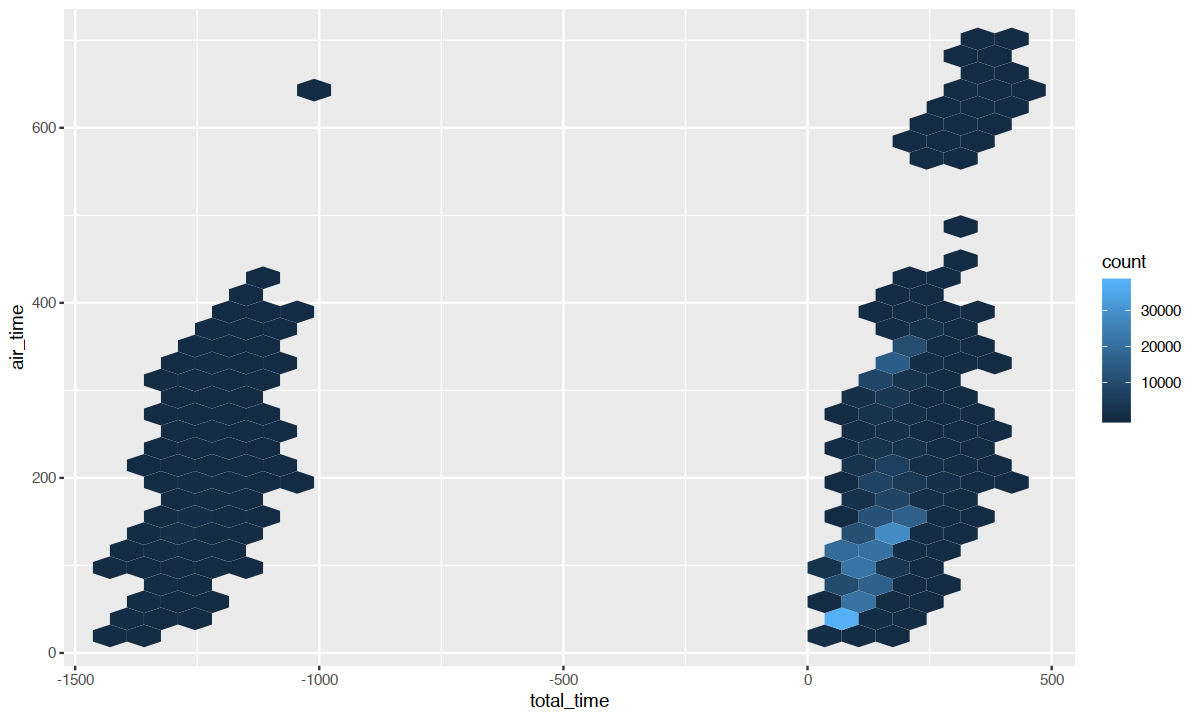

In [88]:
ggplot(my_flights) + geom_hex(aes(x=total_time, y=air_time))

What would cause a discrepancy of 1500m?

## Exercise
Add a new variable to `new_total_time` to `my_flights` which contains a "corrected" version of `total_time`. Plot the resulting distribution of `new_total_time`.

Warning message:
“Removed 9430 rows containing non-finite values (stat_binhex).”

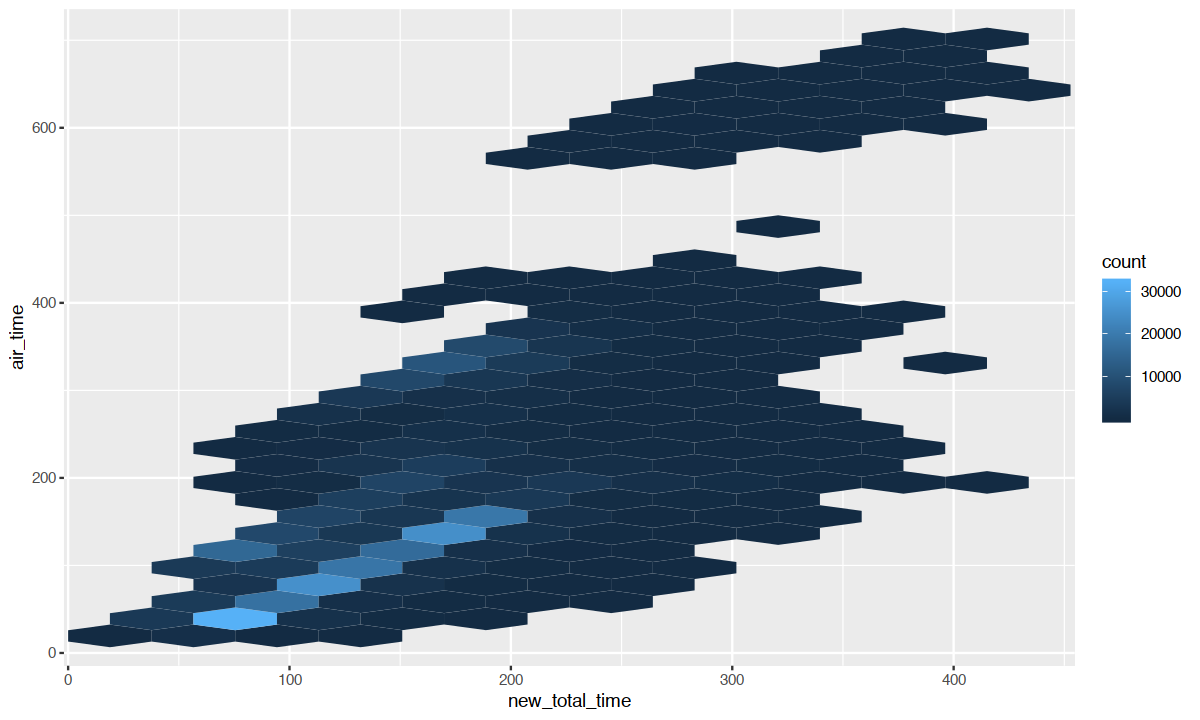

In [102]:
my_flights = mutate(flights, 
                    new_arr = hourmin2min(arr_time), 
                    new_dep = hourmin2min(dep_time),
                    total_time = new_arr - new_dep,
                    new_total_time = ifelse(
                        total_time < 0,
                        total_time + 1440,
                        total_time
                    )
                   )
ggplot(my_flights) + geom_hex(aes(x=new_total_time, y=air_time))

## Who is the greatest batter of all time?
The `Lahman` dataset contains information on baseball players.

In [103]:
library(Lahman)
bat <- as_tibble(Batting) %>% print

ERROR: Error in library(Lahman): there is no package called ‘Lahman’


There is one row per player per year:

In [ ]:
bat[2,] %>% print
Lahman::playerInfo('addybo01')

Bob Addy was active in the years 1871-1877. During that time he had $118+51+152+213+310+142+245=1231$ at-bats, and $32+16+54+51+80+40+68=341$ hits. Therefore his career batting average was $341/1241=0.277$.

In [ ]:
filter(bat, playerID == "addybo01") %>% print

### Exercise
By appropriately grouping and summarizing the data, add up all the hits and at-bats for each player across all the years they played, and compute their career batting average. 

Which player(s) has the highest career batting average?

In [ ]:
## Solution

### Always include counts
It is a good idea to include counts of each group when you do a summary. Some groups may have very low numbers of observations, resulting in high variance for the summary statistics. 

What happens if we restrict our batting average calculation to players that had at least 100 at-bats?

In [ ]:
## Solution

## Exercise
Which player had the highest batting average in a single season? After 1920?

In [ ]:
## Solution